In [1]:
import librosa
import matplotlib
import scipy 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
from scipy.signal import lfilter
from dataclasses import dataclass

from pymatreader import read_mat
import soundfile as sf

import phast
import abt

@dataclass
class MatlabData:
    M: np.ndarray
    T: np.ndarray
    I_det: np.ndarray
    greenwood_f: np.ndarray
    mat: object = None
    
    pw: float = 18e-6
    
    @staticmethod
    def read(path: str, m: int = 0, scaling_factor: float = 1.1) -> "MatlabData":
        mat = read_mat(path)
        TIa = mat["Df120"]["TIa"][m] * 1e-3
        TIb = mat["Df120"]["TIb"][m] * 1e-3
        I_det = TIa + TIb 
        I_det = np.nan_to_num(I_det, nan=np.nanmax(I_det, axis=0))
        
        return MatlabData(
            M = mat['Df120']['M'][m] * scaling_factor,
            T = mat['Df120']['T'][m] * scaling_factor,
            I_det = MatlabData.transform_to_virtual(I_det),
            greenwood_f = np.flip(mat['Df120']['Fn'][m] * 1e3),
            mat=mat
        )
        
        
    @staticmethod
    def transform_to_virtual(i_det):
        reshaped = i_det[:, :i_det.shape[1] - 1, :].reshape(-1, i_det.shape[2]).T
        return np.flip(np.c_[reshaped, i_det[-1, -1, :]], axis=0)
    
    @property
    def i_det(self):
        'i_det no cs'
        return self.I_det[:, 4::8]
    
    def spatial_factor(self, fiber_idx, i_det):
        return np.nanmin(i_det, axis=0) / i_det[fiber_idx, :]

    def sigma(self, fiber_idx, i_det):
        return i_det[fiber_idx, :] * 0.06
   

def create_neurogram(fiber_stats, selected_fibers, binsize, duration):
    bins = np.arange(0, duration, binsize)
    data = np.zeros((len(selected_fibers), len(bins)))
    for i, fiber_idx in enumerate(selected_fibers):
        fs = [fs for fs in fiber_stats if fs.fiber_id == fiber_idx]
        spike_times = phast.spike_times(fs)
        idx = np.digitize(spike_times, bins)
        values, counts = np.unique_counts(idx)
        data[i, values] += counts
    return data

In [2]:
MIN_FREQ = 150
MAX_FREQ = 9350

FS = 17400
NAME = "tone_1kHz"
N_MELS = 80
N_FFT = 2048
N_HOP = N_FFT // 32
CS = False

MEL_SCALE = librosa.filters.mel_frequencies(N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ) 

MAT = MatlabData.read("Fidelity120 HC3A MS All Morphologies 18us CF.mat", scaling_factor=1)

IDET = MAT.i_det if not CS else MAT.I_det

pulse_train, audio_signal = abt.wav_to_electrodogram(
    abt.sounds[NAME], 
    current_steering=CS, 
    charge_balanced=False,  
    virtual_channels=True,
    apply_audiomixer=False,
    ramp_type = 'cs',
    M=MAT.M * 1000,
    T=MAT.T * 1000,
    Fs = FS,
    stim_db = 67,
    ramp_duration=0.1
)

audio_signal = audio_signal[0]

S = librosa.feature.melspectrogram(y=audio_signal, sr=FS, n_fft=N_FFT, hop_length=N_HOP, n_mels=N_MELS, fmin=MIN_FREQ, fmax=MAX_FREQ)
ref_db = np.max(S)

print(ref_db)
print(S.shape)

stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)
duration = stimulus.t_max * MAT.pw
print(pulse_train.shape)
print(stimulus, duration)

# np.abs(pulse_train.max(axis=1)) / IDET.min(axis=0)

# pulse_train = pulse_train / IDET.min(axis=0).reshape(-1, 1)

# pt = pulse_train.copy()
# pt[pt == 0 ] = 100

# scaler = (IDET.min(axis=0) / (pulse_train.max(axis=1) - np.min(pt, axis=1))).reshape(-1, 1)
# pulse_train *= scaler

pulse_train.max(axis=1) / IDET.min(axis=0)


32.76135
(80, 544)
(15, 111090)
<PulseTrain n_pulses: 55545 duration : 1.999620> 1.99962


array([1.14106744, 1.42672186, 1.48570312, 1.72537928, 2.24315753,
       2.65278   , 2.46516185, 1.51736364, 1.02781877, 0.74462498,
       0.85444532, 0.95344522, 0.99652922, 0.99018796, 0.94008498])

In [5]:
abt.utils.virtual_channel_frequencies(16)

array([ 339.84375   ,  453.125     ,  566.40625   ,  657.03125   ,
        781.640625  ,  917.578125  , 1060.37632042, 1262.21161913,
       1529.296875  , 1805.01358696, 2143.90791223, 2551.37695312,
       3027.07201087, 3571.875     , 4251.66223404, 8632.03125   ])

NameError: name 'ELECTRODE_FREQ_EDGES' is not defined

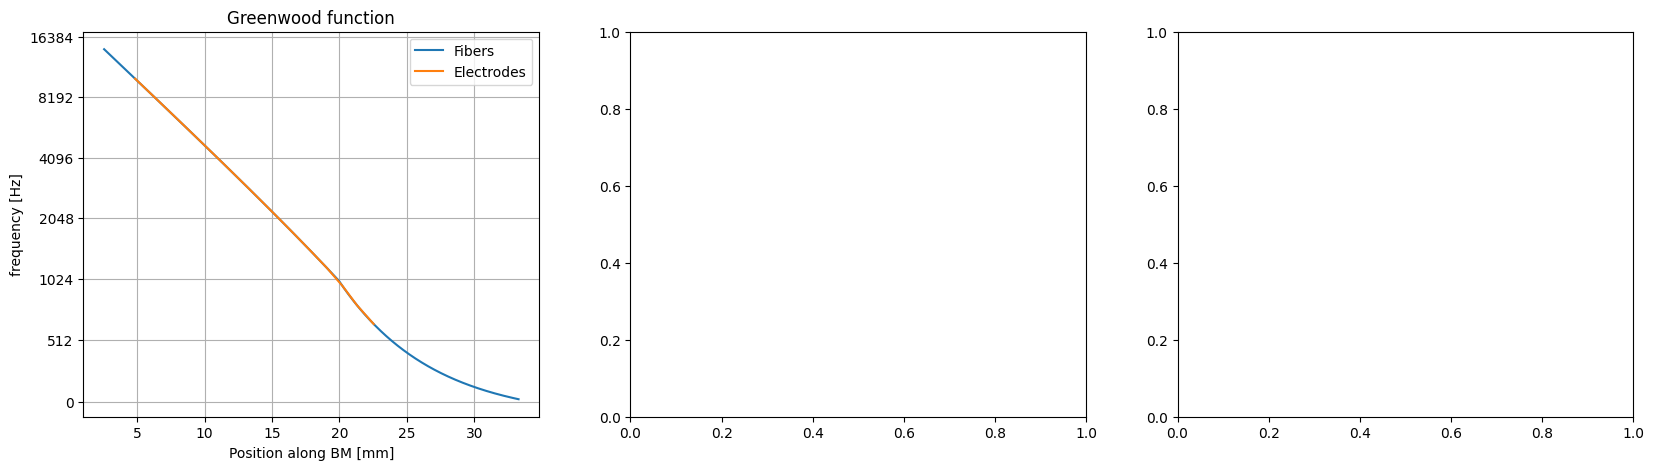

In [4]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

ax1.plot(MAT.mat['Df120']['Ln'][0], MAT.mat['Df120']['Fn'][0] * 1e3, label="Fibers")
ax1.plot(MAT.mat['Df120']['Le'][0], MAT.mat['Df120']['Fe'][0] * 1e3, label="Electrodes")
ax1.set_xlabel("Position along BM [mm]")
abt.utils.frequency_ax(ax1)
ax1.legend()
ax1.grid()
ax1.set_title("Greenwood function")

electrodes = np.arange(1, 17)
gwf_min_thresh = MAT.greenwood_f[np.argmin(MAT.I_det[:,::8], axis=0)]

ax2.plot(electrodes, ELECTRODE_FREQ_EDGES, label="Electrodes")
ax2.plot(electrodes, gwf_min_thresh, label="GW freq min threshold Fiber")


# ax2.legend()
# ax2.grid()
# ax2.set_title("AB Electrode spec")
# ax2.set_xlabel("Electrode")
# frequency_ax(ax2)

# # Remapping selected fibers
# min_thresh_fiber_idx = np.argmin(MAT.I_det[:,::8], axis=0)

# f = scipy.interpolate.interp1d(
#     np.r_[0, min_thresh_fiber_idx], 
#     np.r_[MAT.greenwood_f[0], ELECTRODE_FREQ_EDGES], 
#     fill_value='extrapolate'
# )

# fidx = np.arange(0, 3200)
# int_freq = f(fidx)

# gwf = MAT.greenwood_f.copy()
# gwf_scaled = gwf * .6

# selected_fibers_gw = np.array([find_nearest_idx(gwf, val) for val in MEL_SCALE])
# selected_fibers_gw_scaled = np.array([find_nearest_idx(gwf_scaled, val) for val in MEL_SCALE])
# selected_fibers_est = np.array([find_nearest_idx(int_freq, val) for val in MEL_SCALE])

# p = ax3.plot(fidx, gwf, label="GW f")
# ax3.scatter(selected_fibers_gw, gwf[selected_fibers_gw], color=p[0].get_color(), label='selected fibers')
# p = ax3.plot(fidx, f(fidx), label="Estimated freq")
# ax3.scatter(selected_fibers_est, int_freq[selected_fibers_est], color=p[0].get_color(), label='selected fibers')

# p = ax3.plot(fidx, gwf_scaled, label="Scaled GW f")
# ax3.scatter(selected_fibers_gw_scaled, gwf_scaled[selected_fibers_gw_scaled], color=p[0].get_color(), label='selected fibers')


# ax3.legend()
# ax3.set_xlabel("fiber id")
# frequency_ax(ax3)
# ax3.grid()
# ax3.set_title("GW f vs Est. Freq. based on min thres");

# # Using estimated fibers
# # selected_fibers = selected_fibers_est
# # selected_fibers_freq = int_freq[selected_fibers]

# # Using scaled Gw function
# selected_fibers = selected_fibers_gw_scaled
# selected_fibers_freq =  gwf_scaled[selected_fibers]

# # Using original Gw function
# # selected_fibers = selected_fibers_gw
# # selected_fibers_freq =  gwf[selected_fibers]



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f4ab7f54290>>
Traceback (most recent call last):
  File "/home/nobeljpde1/abt/venv/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
KeyboardInterrupt: 


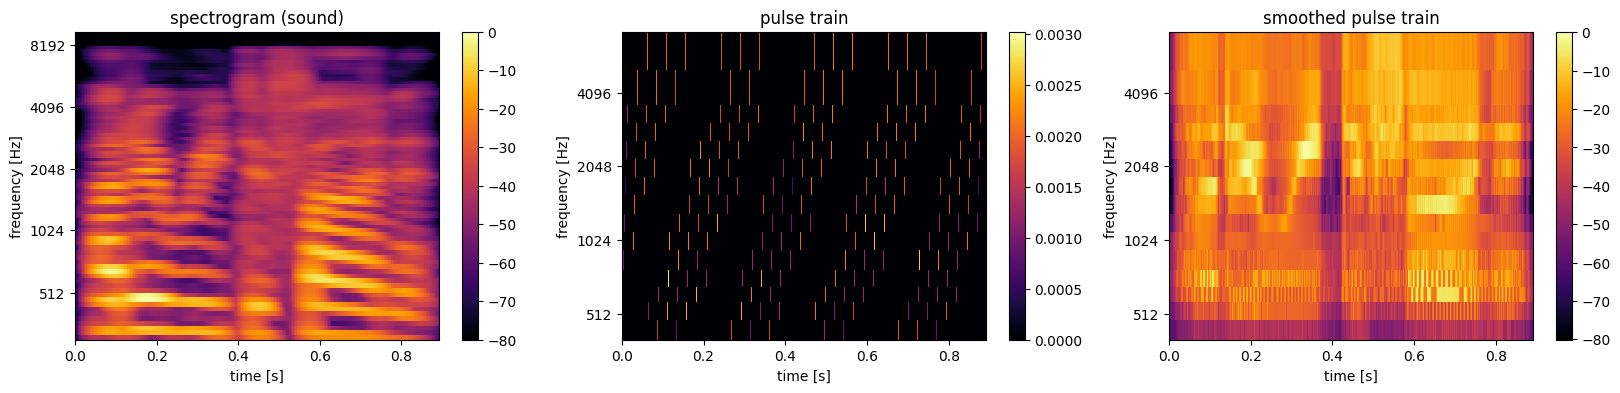

In [8]:
pdata = np.abs(pulse_train)
pdata = apply_filter(pdata, window_size=256, resample_to=pdata.shape[1], scale=True)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

S_db = librosa.power_to_db(S, ref=np.max)
ts = np.linspace(0, duration, len(S_db[0]))

plot_heatmap(ts, MEL_SCALE, S_db, ax1, f)
ax1.set_title("spectrogram (sound)")

plot_heatmap(
    np.arange(pulse_train.shape[1]) * MAT.pw,
    ELECTRODE_FREQ_CENTERS,
    np.abs(pulse_train),
    ax=ax2,
    fig=f
)

ax2.set_title("pulse train")
plot_heatmap(
    np.arange(pulse_train.shape[1]) * MAT.pw,
    ELECTRODE_FREQ_CENTERS,
    pdata,
    ax=ax3,
    fig=f
)
ax3.set_title("smoothed pulse train");

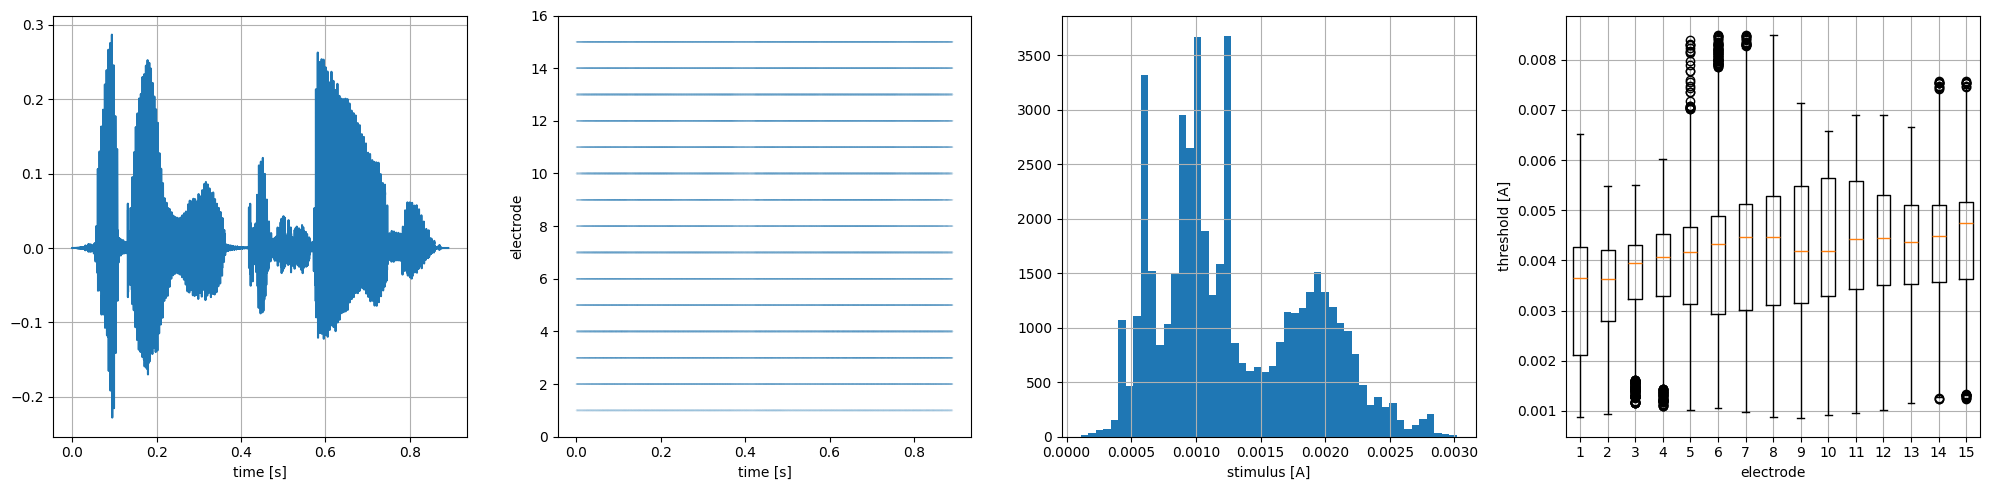

In [ ]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(20, 5))

t_audio = np.arange(len(audio_signal)) * 1 / FS
ax1.plot(t_audio, audio_signal)
ax1.set_xlabel("time [s]")
ax1.grid()

e, t = np.where((pulse_train) > 0)
ax2.scatter(t * MAT.pw, e + 1, s=np.abs(pulse_train[e, t]))
ax2.set_ylim(1, pulse_train.shape[0])
ax2.set_xlabel("time [s]")
ax2.set_ylabel("electrode")
ax2.set_ylim(0, pulse_train.shape[0] + 1)

ax3.hist(np.abs(pulse_train[pulse_train > 0]), bins=50)
ax3.set_xlabel("stimulus [A]")
ax3.grid()

ax4.boxplot(IDET)
ax4.set_ylabel("threshold [A]")
ax4.set_xlabel("electrode")
ax4.grid()

plt.tight_layout()


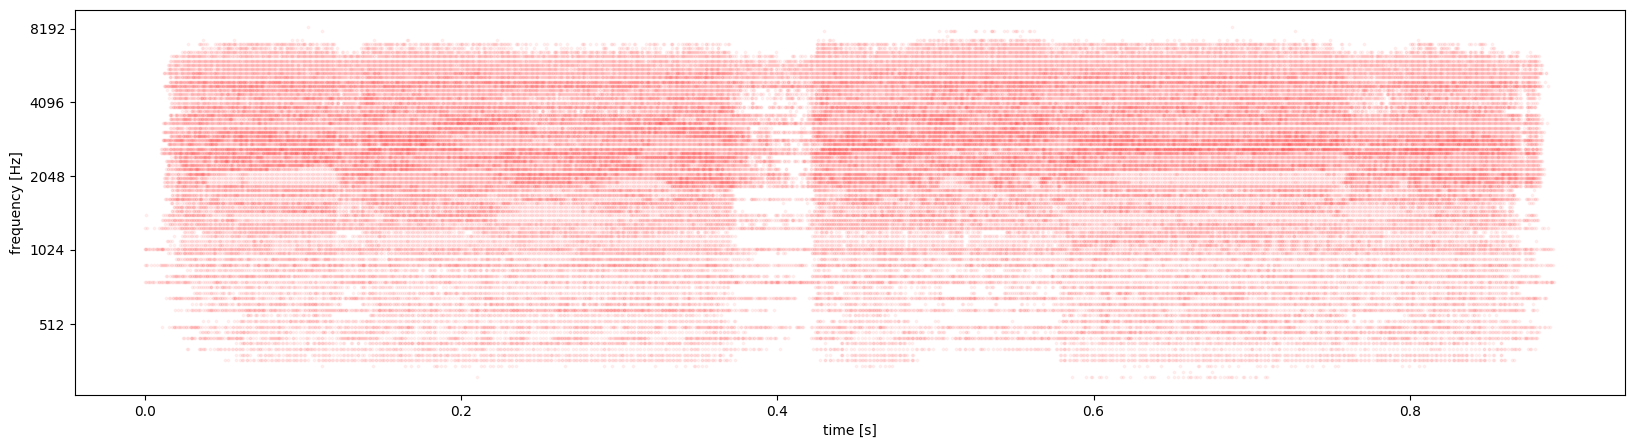

In [ ]:
stimulus = phast.PulseTrain(pulse_train, time_step=MAT.pw)

decay = phast.LeakyIntegratorDecay(
    # accommodation_amplitude=0.072,
    # adaptation_amplitude=7.142,
    # accommodation_rate=0.014,
    # adaptation_rate=19.996
)

fibers = []
for fiber_idx in selected_fibers:
    fibers.append(
        phast.Fiber(
            i_det=IDET[fiber_idx],
            # spatial_constant=np.ones(IDET.shape[0]), 
            spatial_constant=MAT.spatial_factor(fiber_idx, IDET) * .1,
            sigma=MAT.sigma(fiber_idx, IDET),  
            fiber_id=fiber_idx,
            n_max=stimulus.n_pulses,  
            decay=decay,  
            store_stats=False,
        )
    )
    

fiber_stats = phast.phast(fibers, stimulus, generate_trials = 10, evaluate_in_parallel=True)

duration = stimulus.time_step * stimulus.t_max
binsize = 1e-5

neurogram = create_neurogram(fiber_stats, selected_fibers, binsize, duration)
del fiber_stats
import gc;gc.collect()

plt.figure(figsize=(20, 5))
for y in range(len(selected_fibers)):
    x = np.where(neurogram[y, :])[0]
    y = selected_fibers_freq[y]
    plt.scatter(x * binsize, y * np.ones(len(x)), color="red", alpha=.05, s=3)
    
time_vs_freq()


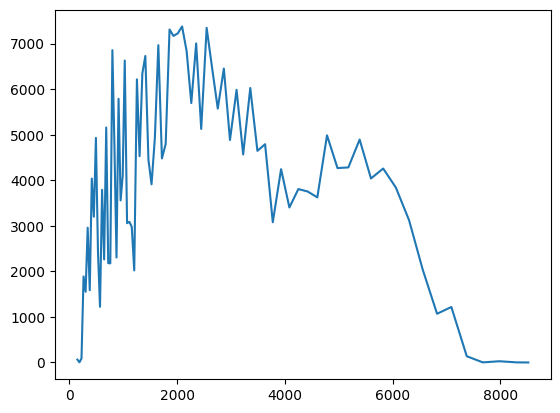

In [ ]:
plt.plot(selected_fibers_freq, neurogram.sum(axis=1))

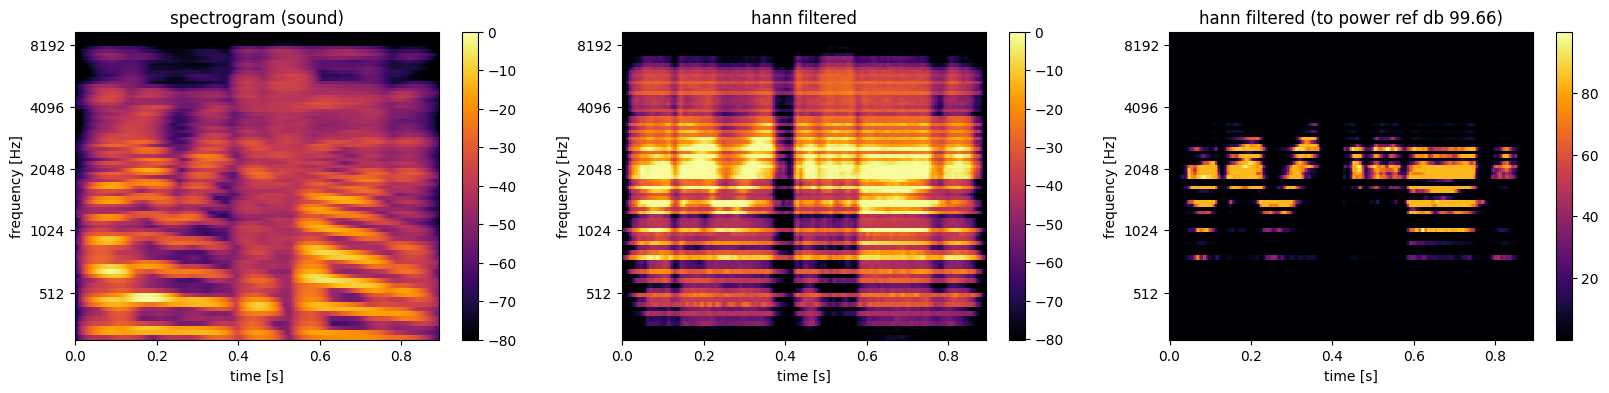

In [ ]:
f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20, 4))

plot_heatmap(ts, MEL_SCALE, S_db, ax0, f)
ax0.set_title("spectrogram (sound)")

filtered_data = apply_filter(neurogram, resample_to=S.shape[1])

t = np.linspace(0, duration, len(filtered_data[0]))
plot_heatmap(t, MEL_SCALE, filtered_data, ax=ax1, fig=f)
ax1.set_title("hann filtered")

ref_db = np.max(S)
mel_spec_ng = librosa.db_to_power(filtered_data, ref=ref_db)
plot_heatmap(t, MEL_SCALE, mel_spec_ng, ax=ax2, fig=f)
ax2.set_title(f"hann filtered (to power ref db {ref_db:.2f})");


In [ ]:
mel_inversed = librosa.feature.inverse.mel_to_audio(mel_spec_ng,  n_fft=N_FFT, hop_length=N_HOP, sr=FS, fmin=MIN_FREQ, fmax=MAX_FREQ)

mel_inversed = scipy.signal.resample(mel_inversed, audio_signal.size)

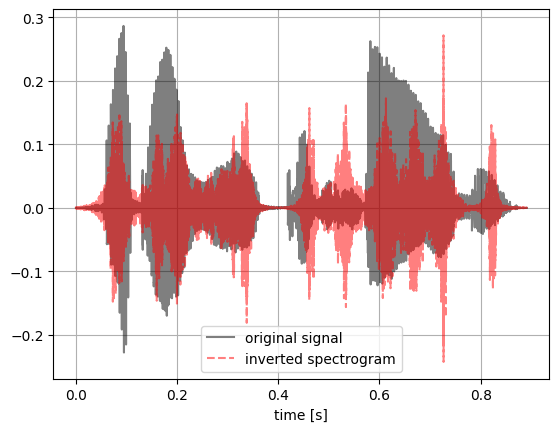

In [ ]:
sc = (audio_signal.max() - audio_signal.min()) / (mel_inversed.max() - mel_inversed.min())
mel_inversed *= sc

t_audio = np.arange(len(audio_signal)) * 1 / FS
plt.plot(t_audio, audio_signal, label="original signal", color="black", alpha=.5)
plt.xlabel("time [s]")

t_mel = np.arange(len(mel_inversed)) * 1 / FS

plt.plot(
    t_mel, 
    mel_inversed,
    label="inverted spectrogram", 
    color ="red", 
    linestyle="dashed", 
    alpha=.5
)

mel_filt = scipy.signal.savgol_filter(mel_inversed, 64, 2) 
mel_filt *= (audio_signal.max() - audio_signal.min()) / (mel_filt.max() - mel_filt.min())

# plt.plot(
#     t_mel, mel_filt,
#     label="inverted spectrogram (filtered)", color ="blue", linestyle="dashed", alpha=.5
# )
plt.grid()
plt.legend()

sf.write(
    f"output/{NAME}.wav", audio_signal, FS, subtype='PCM_24'
)

sf.write(
    f"output/mel_reconstructed_{NAME}_filt.wav", mel_filt, FS, subtype='PCM_24'
)

sf.write(
    f"output/mel_reconstructed_{NAME}_ci.wav", mel_inversed, FS, subtype='PCM_24'
)


# n = int(np.ceil(mel_inversed.size * (16000 / FS)))
# mp3 = scipy.signal.resample(mel_inversed, n)
# sf.write(
#         f"output/mel_reconstructed_{NAME}_ci.mp3", mp3, 16000,
#         format='MP3', subtype='MPEG_LAYER_III'
# )




In [ ]:
mel_inversed.size, audio_signal.size



(15507, 15507)

In [ ]:
FS

17400